In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import concat, lit, avg, round
from pyspark import SparkContext, SparkConf
import matplotlib.pyplot as plt
import time

spark = SparkSession.builder.master('local[*]').getOrCreate()
#spark.conf.set('spark.cores.max', '1')
#spark.conf.set('spark.driver.memory','1000M')

sc = spark.sparkContext

spark

In [2]:
spark.sparkContext.defaultParallelism

4

In [3]:
 df = spark.read.format("csv").option("inferSchema", "true").option("timestampFormat","yyyy-MM-dd HH:mm:ss").option("header", "true").option("mode", "DROPMALFORMED").load("tripdata_2017_01.csv")

In [4]:
df.count()

971010

In [5]:
!rm -r small
df.limit(10000).write.option("header", True).option("timestampFormat","yyyy-MM-dd HH:mm:ss").csv("small")   #specifying the csv is necessary
#write is a method of df wit which I obtain the same amount of data, so we limit
#write is an action
#a single file with 10000 rows is created

In [ ]:
df2 = spark.read.parquet("yellow_tripdata_2023-07.parquet") 

In [ ]:
df2.count()

## CASE STUDIES
- Tips depending on the route
- Average speed of taxis in terms of the hour.
- Fare-amount (o total amount) depending on distance and datetimes to calculate the flag drop

### 1. Tips depending on the route (based on PULocation and DOLocation)

In [6]:
#Reading the reduced trip_data dataframe
df3 = spark.read.format("csv").option("inferSchema", "true").option("timestampFormat","yyyy-MM-dd HH:mm:ss").option("header", "true").option("mode", "DROPMALFORMED").load("small")

In [7]:
df3.printSchema() #list of all columns that are part of the file

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- tpep_dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: integer (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)



In [8]:
#Transform dataframe into a Pandas
df_pandas = df3.toPandas() #returns a panda object

/usr/local/spark/python/pyspark/sql/pandas/conversion.py:251: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)
/usr/local/spark/python/pyspark/sql/pandas/conversion.py:251: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


In [9]:
df3 = spark.createDataFrame(df_pandas)

In [10]:
#Reading the locations dataframe
df_locations = spark.read.format("csv").option("inferSchema", "true").option("timestampFormat","yyyy-MM-dd HH:mm:ss").option("header", "true").option("mode", "DROPMALFORMED").load("taxi+_zone_lookup.csv")

In [11]:
#Selecting the columns we want to keep before joining: LocationID, Borough
columns_loc = df_locations.select("LocationID", "Borough")
columns_loc.show(5)

+----------+-------------+
|LocationID|      Borough|
+----------+-------------+
|         1|          EWR|
|         2|       Queens|
|         3|        Bronx|
|         4|    Manhattan|
|         5|Staten Island|
+----------+-------------+
only showing top 5 rows



In [12]:
#Joining both dataframes where DOLocationID = LocationID
df_join = df3.join(columns_loc, df3["DOLocationID"] == columns_loc["LocationID"])
df_join.printSchema()

root
 |-- VendorID: long (nullable = true)
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- tpep_dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: long (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: long (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: long (nullable = true)
 |-- DOLocationID: long (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- LocationID: integer (nullable = true)
 |-- Borough: string (nullable = true)



In [13]:
#Renaming Borough as ArrivalZone 
df_join = df_join.withColumnRenamed("Borough", "ArrivalZone")

In [14]:
#Deleting the columns we do not want anymore: LocationID and DOLocationID
df_join = df_join.drop("LocationID", "DOLocationID")
df_join.printSchema()

root
 |-- VendorID: long (nullable = true)
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- tpep_dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: long (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: long (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: long (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- ArrivalZone: string (nullable = true)



In [15]:
#Now we perform a second join to combine both dataframes where PULocationID = LocationID
final_df = df_join.join(columns_loc, df_join["PULocationID"] == columns_loc["LocationID"])
final_df.printSchema()

root
 |-- VendorID: long (nullable = true)
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- tpep_dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: long (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: long (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: long (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- ArrivalZone: string (nullable = true)
 |-- LocationID: integer (nullable = true)
 |-- Borough: string (nullable = true)



In [16]:
#Renaming Borough as DepartureZone 
final_df = final_df.withColumnRenamed("Borough", "DepartureZone")

In [17]:
#Deleting the columns we do not want anymore: LocationID and PULocationID
final_df = final_df.drop("LocationID", "PULocationID")
final_df.printSchema()

root
 |-- VendorID: long (nullable = true)
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- tpep_dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: long (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: long (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- ArrivalZone: string (nullable = true)
 |-- DepartureZone: string (nullable = true)



In [18]:
#Finally, we unify columns DepartureZone and ArrrivalZone in a column named route

final_df = final_df.withColumn("route", concat(final_df.DepartureZone, lit(" "), final_df.ArrivalZone))
final_df.show()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+-----------+-------------+-------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|ArrivalZone|DepartureZone|              route|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+-----------+-------------+-------------------+
|       1| 2017-01-09 11:13:28|  2017-01-09 11:25:45|              1|          3.3|         1|                 N|           1|       12.5|  0.0|    0.5|       2.0|         0.0|                  0.3|        15.3|  Manhattan|   

In [19]:
#Deleting the columns we do not want anymore: ArrivalZone and DepartureZone
final_df = final_df.drop("ArrivalZone", "DepartureZone")
final_df.printSchema()

root
 |-- VendorID: long (nullable = true)
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- tpep_dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: long (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: long (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- route: string (nullable = true)



Now, the data is ready: we have the routes followed by the passengers

In [20]:
#We create a new dataframe "study_1" only with the columns needed to perform the study: Tip_amount and route
study_1 = final_df.select("Tip_amount", "route")
study_1.show(5)

+----------+-------------------+
|Tip_amount|              route|
+----------+-------------------+
|       2.0|Manhattan Manhattan|
|      1.45|Manhattan Manhattan|
|       1.0|Manhattan Manhattan|
|       1.7|Manhattan Manhattan|
|       0.0|Manhattan Manhattan|
+----------+-------------------+
only showing top 5 rows



To complete the first study, we have decided to calculate the average of tips paid by the passengers on the route.

The steps that have been followed are:
- groupBy(): In order to classify the tips based on the route
- agg(): An aggregate function to calculate the average using avg()
- orderBy(): To sort the tips in descending order

In [21]:
#What do we do with the unknown: delete
avg_tips = study_1.groupBy('route').agg(round(avg('Tip_amount'), 2).alias('Average_Tip_per_Route')).orderBy('Average_Tip_per_Route', ascending=False)

In [22]:
#Showing the results and calculating the execution time
start = time.time()
avg_tips.show() #as it is he action --> measure execution time here
end = time.time()
exec_time = end  - start
print(exec_time)

+--------------------+---------------------+
|               route|Average_Tip_per_Route|
+--------------------+---------------------+
|          Queens EWR|                19.15|
|         Unknown EWR|                18.31|
|             EWR EWR|                14.61|
|      Queens Unknown|                11.04|
|       Manhattan EWR|                 8.25|
|    Unknown Brooklyn|                 8.09|
|      Unknown Queens|                 7.13|
|Manhattan Staten ...|                 7.11|
|Queens Staten Island|                 6.99|
|        Bronx Queens|                 5.57|
|    Queens Manhattan|                 4.85|
|     Queens Brooklyn|                 4.02|
|      Brooklyn Bronx|                 3.82|
|    Manhattan Queens|                 3.54|
|     Brooklyn Queens|                 2.71|
|  Brooklyn Manhattan|                 2.43|
|  Manhattan Brooklyn|                 2.21|
|   Manhattan Unknown|                 1.87|
|     Unknown Unknown|                 1.74|
|        Q

In [ ]:
#Keeping execution time in every execution
exec_times = [0,0,0.6832952499389648,1.6662144660949707]
cores_num = np.range(4)

Text(0.5, 1.0, 'Average Tip per Route')

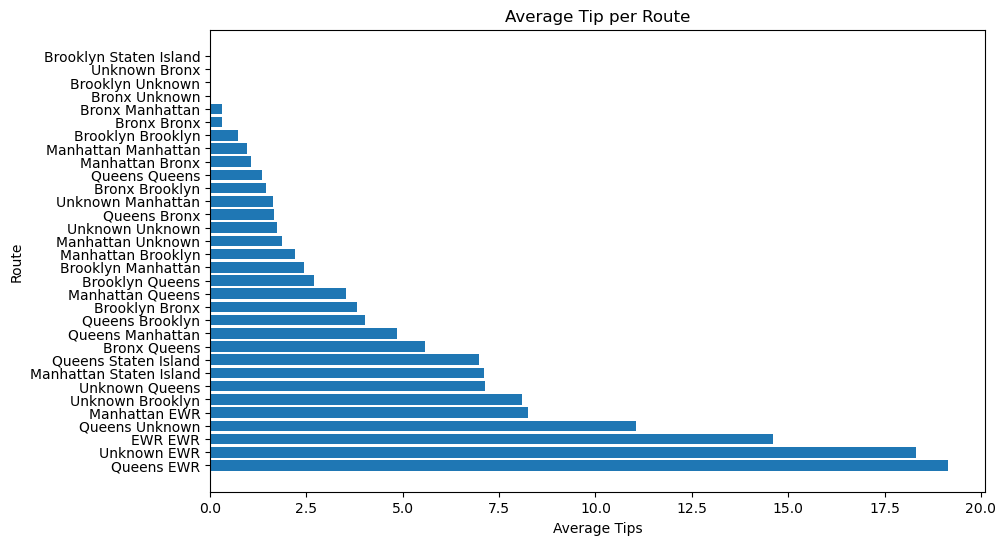

In [23]:
#We transform the data into pandas in order to plot the results

avg_tips_pd = avg_tips.toPandas()

plt.figure(figsize=(10,6))

plt.barh(avg_tips_pd["route"], avg_tips_pd["Average_Tip_per_Route"])
plt.xlabel("Average Tips")
plt.ylabel("Route")
plt.title("Average Tip per Route")